In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


## Choosing a model

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image preprocessing

In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f4877c9ab80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text preprocessing

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Setting up input images and texts

Colored MNIST dataset already exists


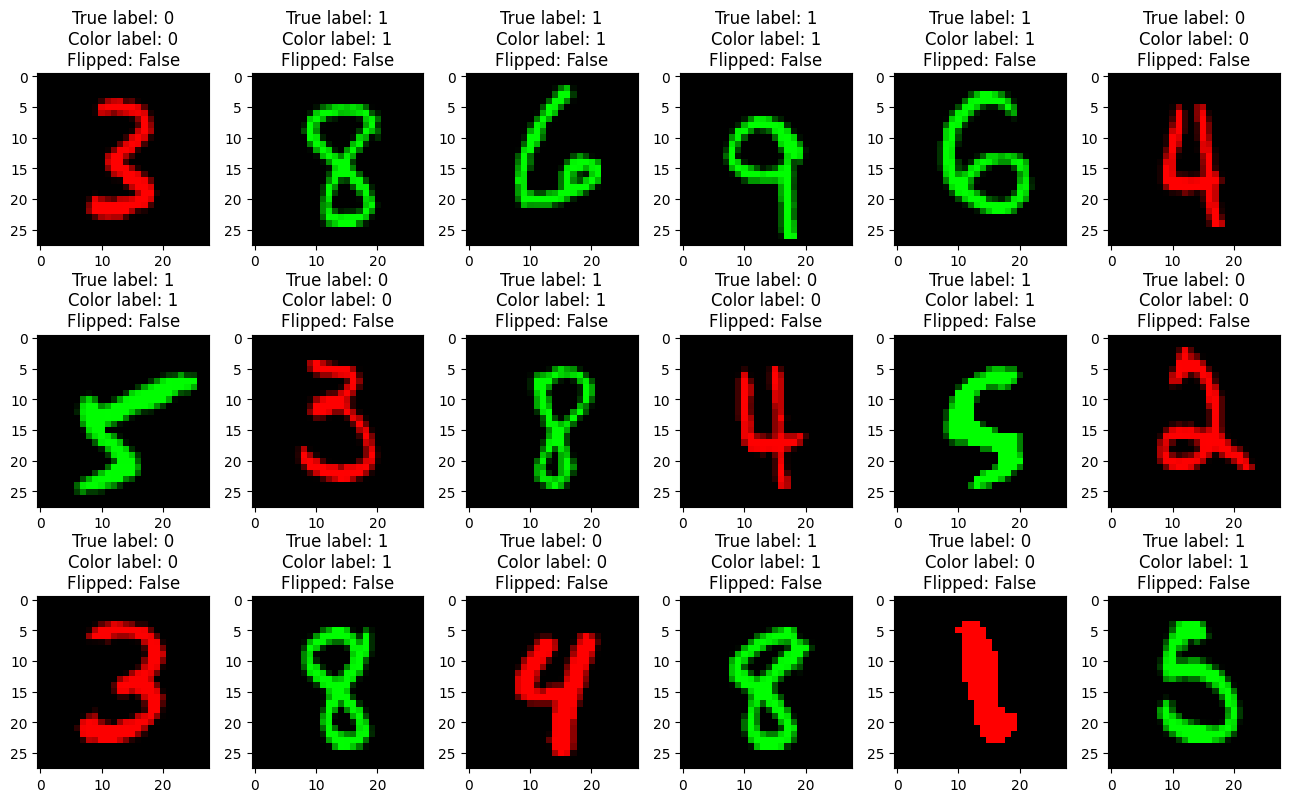

In [8]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

def color_grayscale_arr(arr, green=True):
  """
  Convert grayscale MNIST images to either red or green MNIST images by expanding
  the image to three RGB dimensions. The grayscale image either gets applied to
  the red or green channel.
  """
  assert arr.ndim == 2
  
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  
  if green:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)],axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Downloads the grayscale MNIST dataset and transforms it into a colored MNIST dataset.
  Digits smaller than 5 are colored red for the train and validation set. Numbers larger
  than 5 are colored green for the train and validation set. The colors of the digits have
  a 50% probability to be flipped.
  """
  def __init__(self, root='./data', env='train', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train', 'val', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train, val and test')

  def __getitem__(self, index):
    """
    Overriden method from datasets.VisionDataset to apply transformations to the data
    before providing them to the dataloader.
    """
    img, ground_truth_label, low_high_label, color_label = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      low_high_label = self.target_transform(low_high_label)

    return img, ground_truth_label, low_high_label, color_label

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    """
    Download 60'000 grayscale MNIST images, split them into a train, validation and a test
    dataset and transform them to a colored MNIST dataset.
    """
    
    def mnist_grayscale_to_color():
      def conversion_progress(idx, datasource, phase='train'):
        if idx % 5000 == 0:
            print(f'Converting {phase} image {idx}/{len(datasource)}')
      
      # http://yann.lecun.com/exdb/mnist/
      print('Preparing Colored MNIST')
      train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True) # 60'000 samples for training
      test_mnist = datasets.mnist.MNIST(self.root, train=False, download=True) # 10'000 samples for validation and test

      train_set = []
      validation_set = []
      test_set = []
      
      for dataset in ['train_ds', 'test_ds']:
        datasource = train_mnist if (dataset == 'train_ds') else test_mnist
        
        for idx, (im, ground_truth) in enumerate(datasource):
          # determine train, validation, test phase/split
          if dataset == 'train_ds':
            if idx < 50000:
              phase = 'train'
            else:
              phase = 'validation'
          elif dataset == 'test_ds':
            phase = 'test'
          
          # progress bar
          conversion_progress(idx, datasource, phase)
                
          # Assign binary digit label for small and large numbers
          low_high_label = 1 if ground_truth > 4 else 0

          # Assign random color labels to test set
          if phase == 'test':
            color_label = np.random.choice([0,1])
          else:
            color_label = low_high_label
          
          # Color the digit
          colored_arr = color_grayscale_arr(np.array(im), green=color_label)
          
          # create dataset with:
          # image (tensor format)
          # ground truth label (displayed number)
          # low_high_label (0 for low numbers, 1 for high numbers)
          # color_label (potentially mixed up label for test dataset)
          if phase == 'train':
            train_set.append((Image.fromarray(colored_arr), ground_truth, low_high_label, color_label))
          elif phase == 'validation':
            validation_set.append((Image.fromarray(colored_arr), ground_truth, low_high_label, color_label))
          else:
            test_set.append((Image.fromarray(colored_arr), ground_truth, low_high_label, color_label))
            
      return train_set, validation_set, test_set
      
    
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'val.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return
    
    train_set, val_set, test_set = mnist_grayscale_to_color()

    os.makedirs(colored_mnist_dir, exist_ok=True)
    torch.save(train_set, os.path.join(colored_mnist_dir, 'train.pt'))
    torch.save(val_set, os.path.join(colored_mnist_dir, 'val.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))


def plot_digits(dataset):
    """
    Plots some digits from a provided colored MNIST dataset to be analyzed.
    """
    fig = plt.figure(figsize=(13,8))
    columns = 6
    rows = 3
    ax = []
    
    for i in range(columns*rows):
        img, ground_truth, true_label, color_label = dataset[i]
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("True label: " + str(true_label) + 
                         "\nColor label: " + str(color_label) +
                         "\nFlipped: " + str(true_label != color_label))
        plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))
        
    plt.tight_layout()
    plt.show()

val_set = ColoredMNIST(root='./data',
                          env='val',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(val_set)

In [9]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "0": "a number with the value zero",
    "1": "a number with the value one",
    "2": "a number with the value two",
    "3": "a number with the value three",
    "4": "a number with the value four",
    "5": "a number with the value five",
    "6": "a number with the value six",
    "7": "a number with the value seven",
    "8": "a number with the value eight",
    "9": "a number with the value nine"
}

In [10]:
val_set = ColoredMNIST(root='./data',
                       env='val',
                       transform= transforms.Compose([transforms.ToTensor()]))



Colored MNIST dataset already exists


Colored MNIST dataset already exists


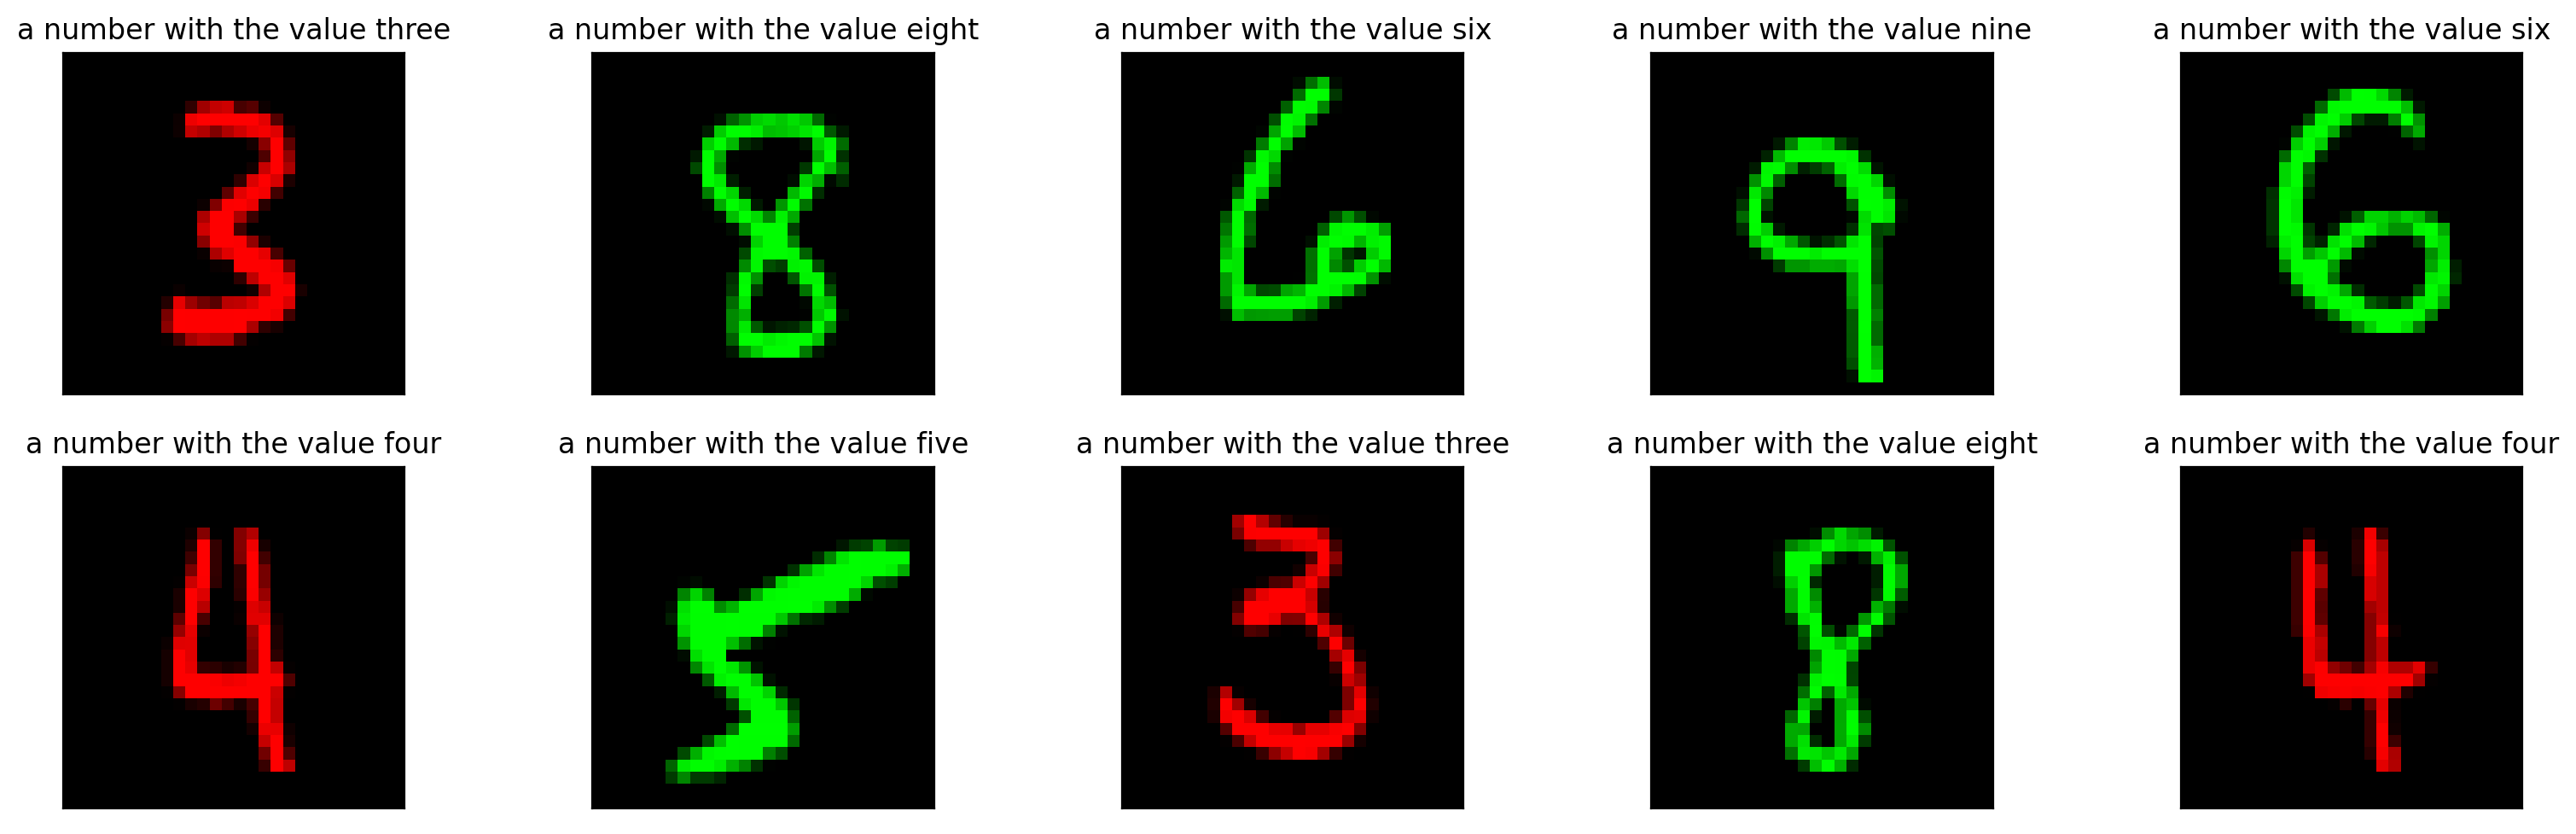

In [25]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

val_set = ColoredMNIST(root='./data',
                       env='val',
                       transform= transforms.Compose([transforms.ToTensor()]))
transform = transforms.ToPILImage()

for i in range(10):

    image = transform(val_set[i][0])
    ground_truth_label = val_set[i][1]
  
    plt.subplot(2, 5, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{descriptions[str(ground_truth_label)]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[str(ground_truth_label)])

plt.tight_layout()

## Building features

In [26]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [27]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

In [28]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

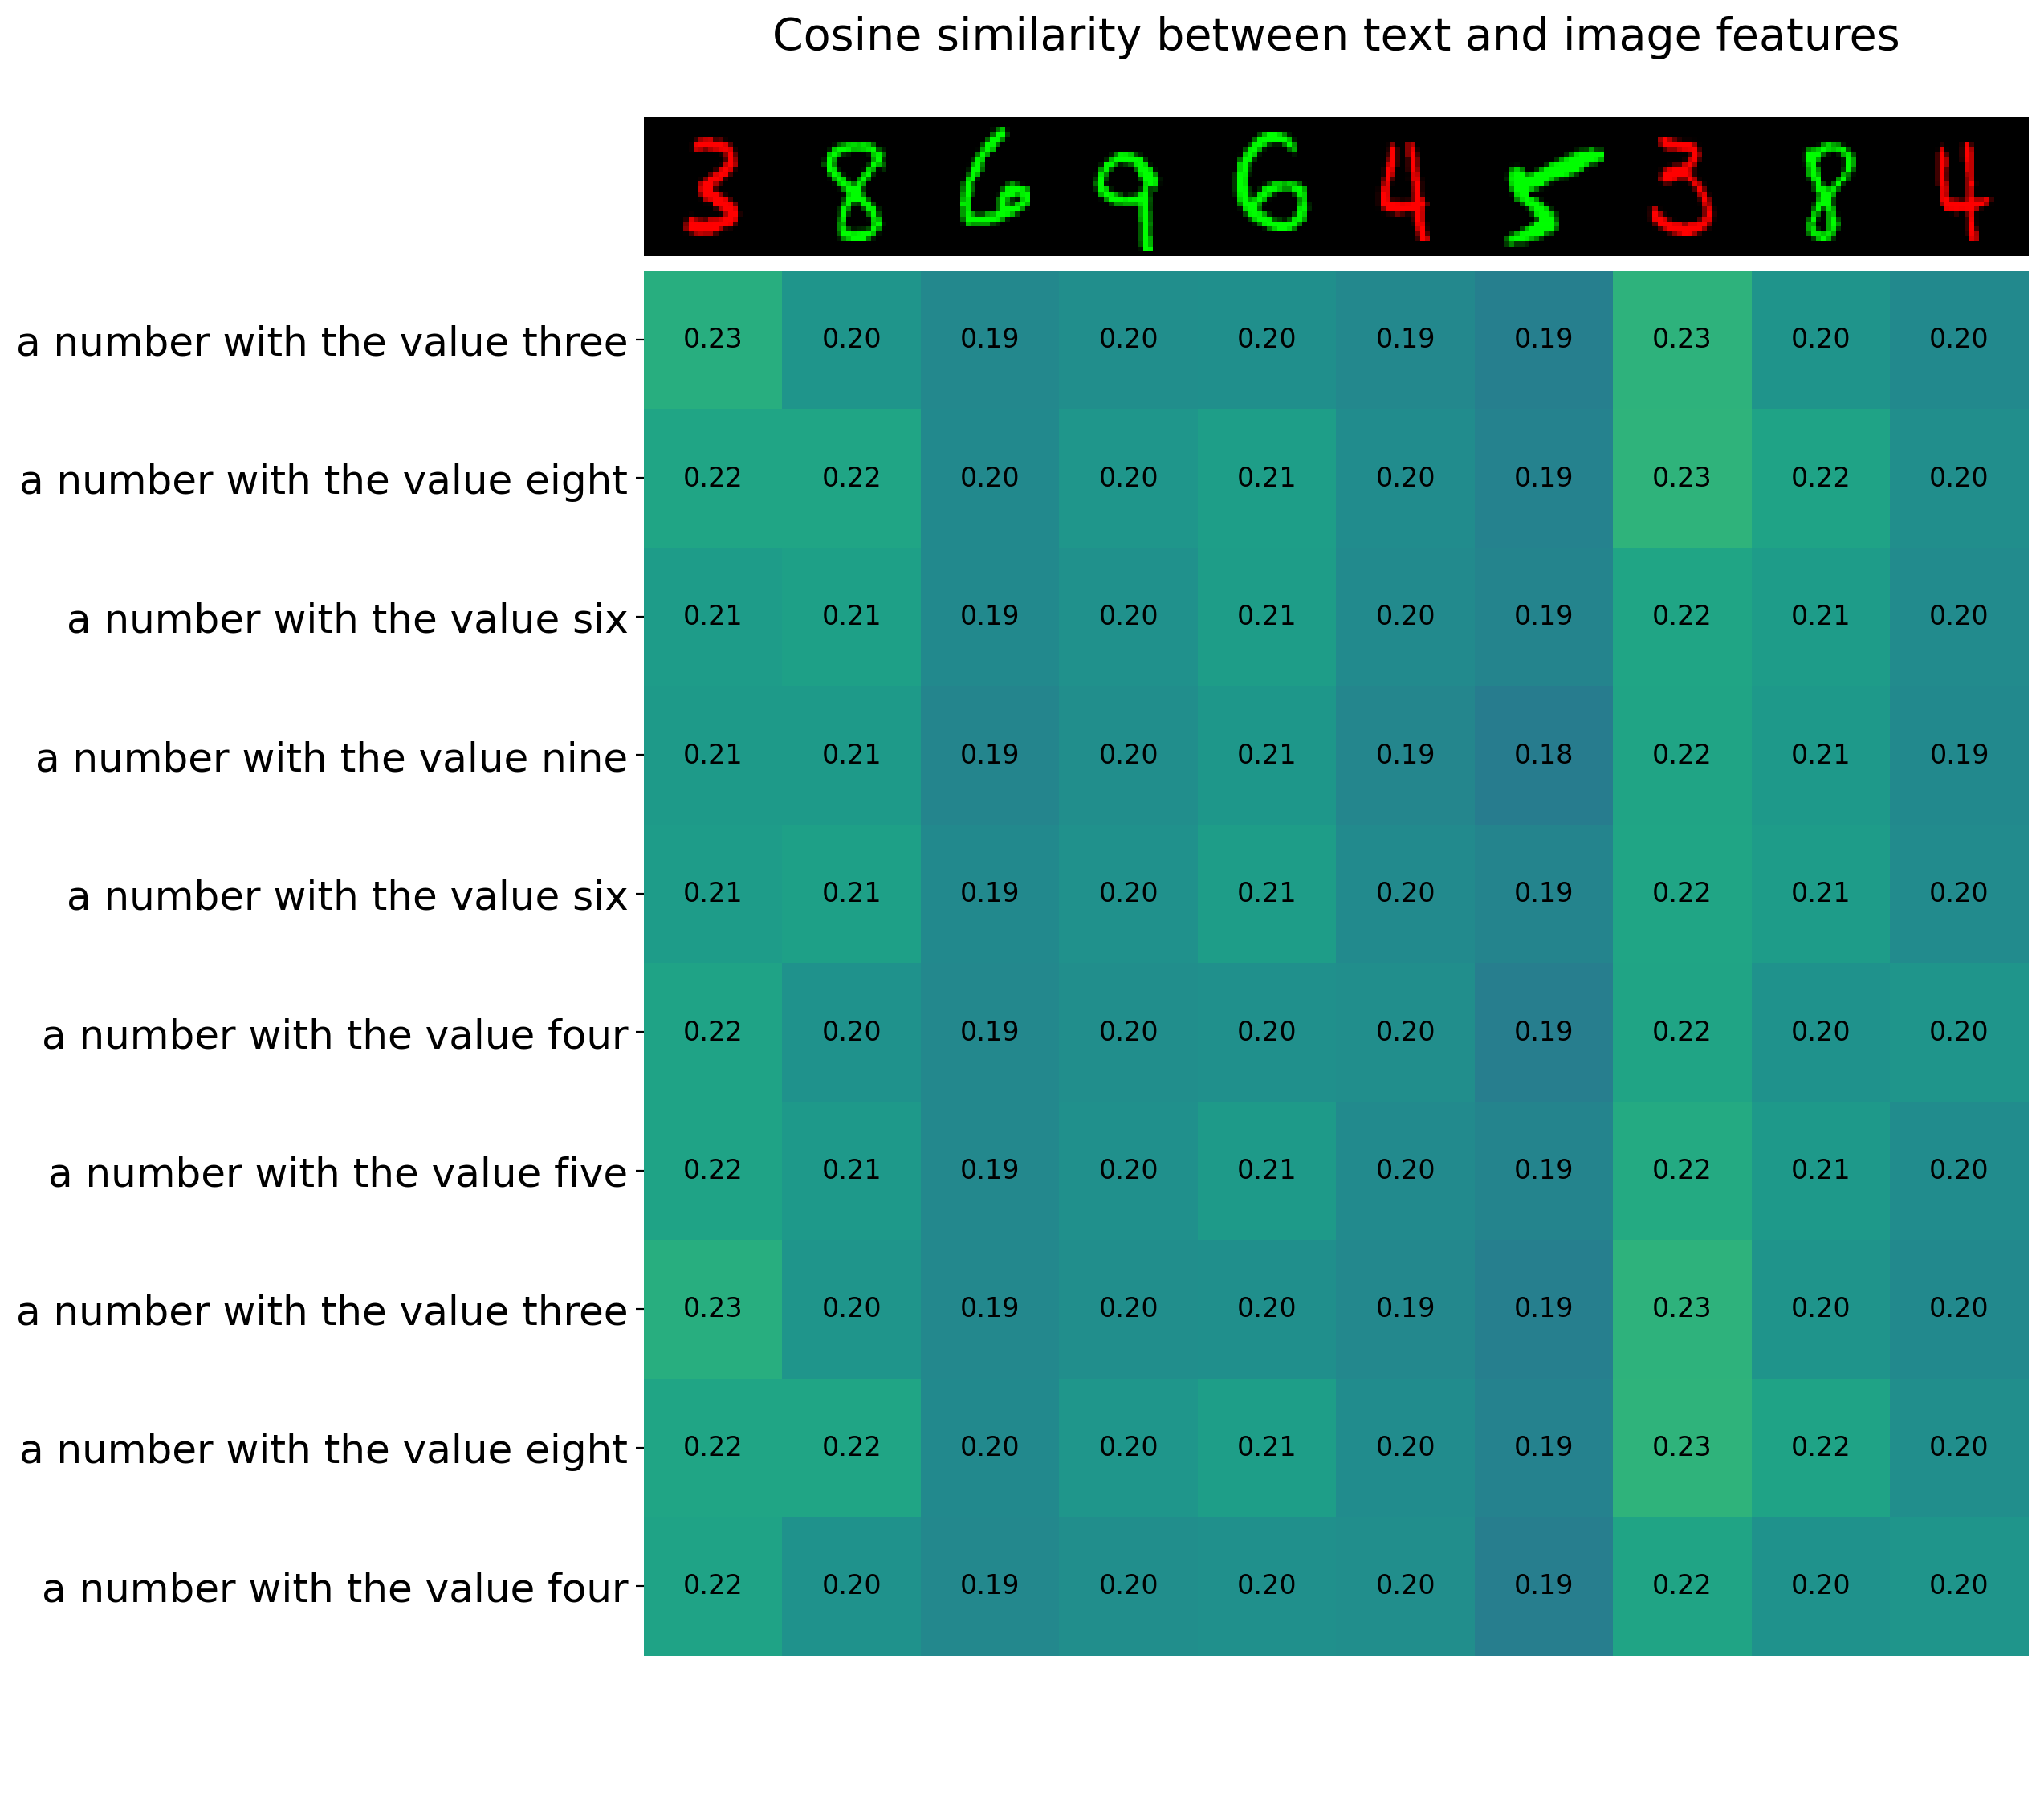

In [29]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Zero-Shot Image Classification

In [30]:
number_classes = []
number_classes.append("zero")
number_classes.append("one")
number_classes.append("two")
number_classes.append("three")
number_classes.append("four")
number_classes.append("five")
number_classes.append("six")
number_classes.append("seven")
number_classes.append("eight")
number_classes.append("nine")
number_classes

['zero',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine']

In [31]:
text_descriptions = [f"This is a photo of a {label}" for label in number_classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [32]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

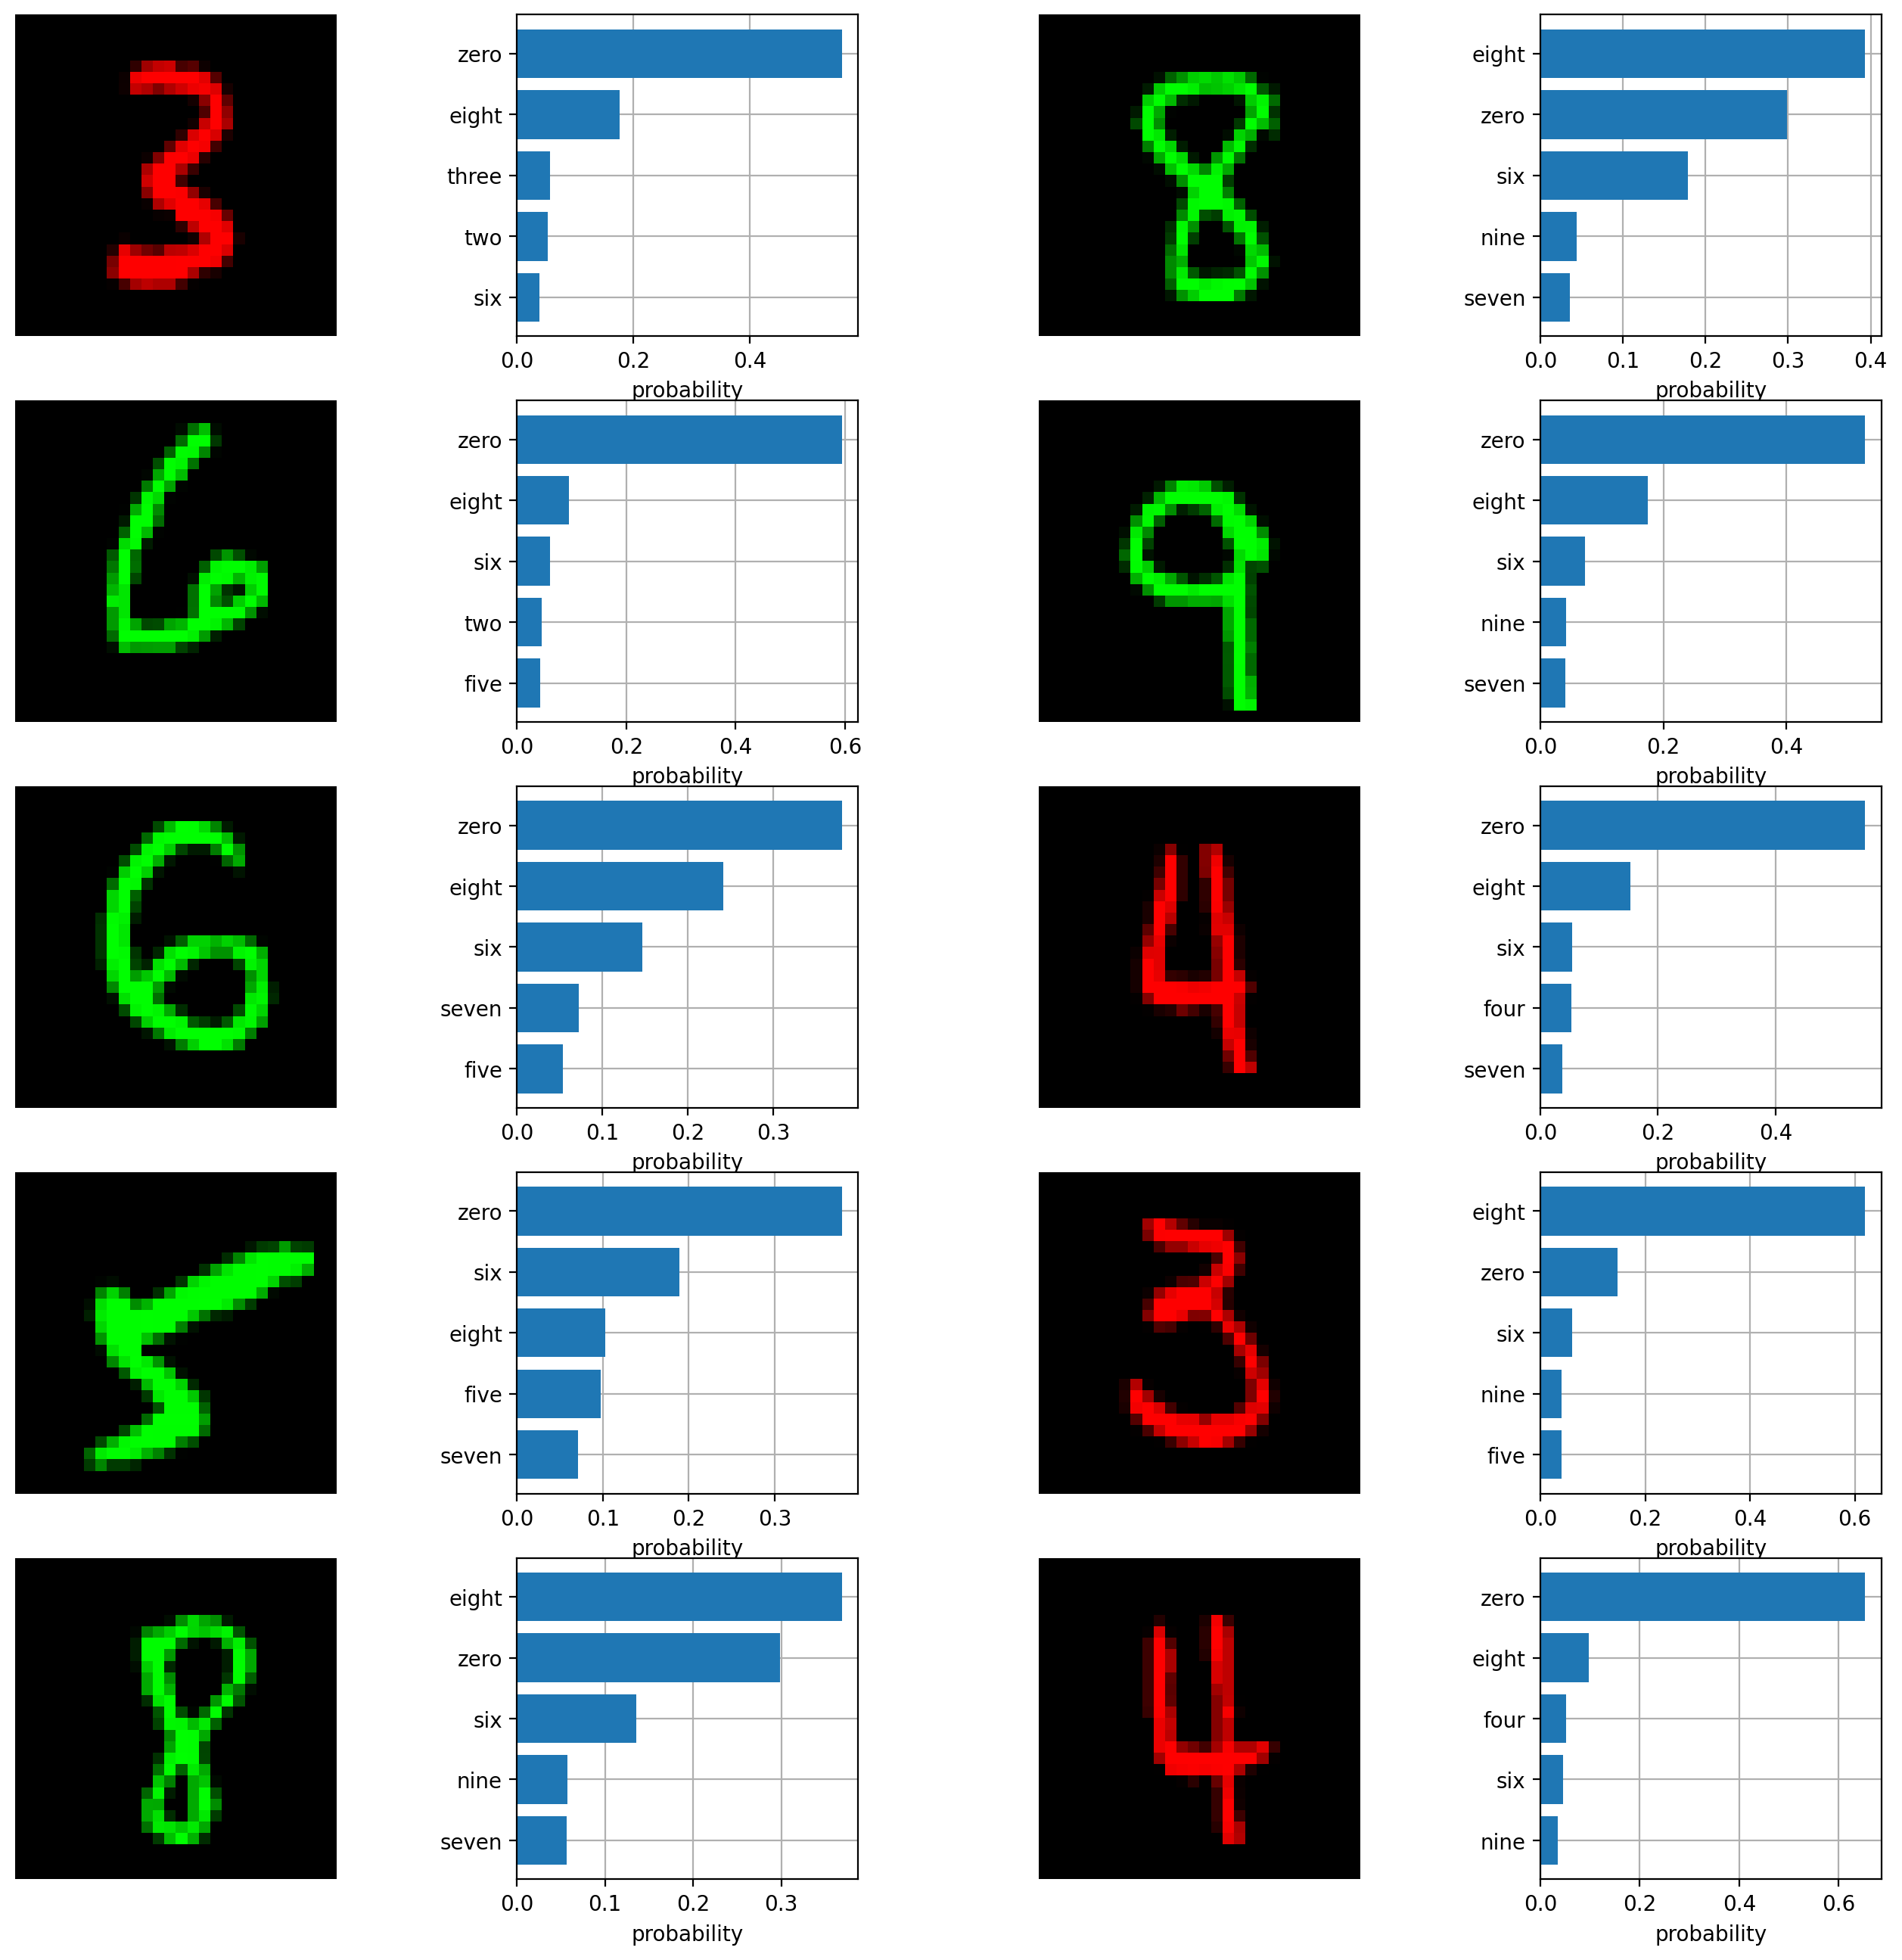

In [39]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [number_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()